In [128]:
# This notebook will explore simple models that are made using spatial CV
#By Amanda Worthy

In [129]:
#import the packages!!

import os
import time
import requests
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import fiona
import shapely.geometry
from shapely.geometry import Point, Polygon, box, shape
from affine import Affine
from rasterio.enums import Resampling
import pyproj
from rasterstats import zonal_stats
from sklearn.model_selection import (
    train_test_split,
    GroupKFold,
    LeaveOneOut,
    cross_val_predict
)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [100]:
#import the USA file 
usa_fxn = "usa.geojson"

usa = gpd.read_file(usa_fxn)

In [130]:
!ls

Modeling_w_spatial_cv.ipynb          environment.yml
Newest_dataset_analysis_python.ipynb usa.geojson
Tree_ds_sep16.csv


In [134]:
#import the tree dataset 
tree_fxn = "Tree_ds_sep16.csv"

tree= pd.read_csv(tree_fxn)

mygeometry_array = gpd.points_from_xy(tree['Longitude'], tree['Latitude'])

tree= gpd.GeoDataFrame(
tree, crs='EPSG:4326', geometry=mygeometry_array)

#tree.head()

In [135]:
tree = tree[~tree['Region'].isin(['California', 'Washington'])]  #okay we are taking it i guess 

In [136]:
tree.head()

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,4_tmin_nClimGrid,5_tmin_nClimGrid,6_tmin_nClimGrid,7_tmin_nClimGrid,8_tmin_nClimGrid,9_tmin_nClimGrid,10_tmin_nClimGrid,11_tmin_nClimGrid,12_tmin_nClimGrid,annual_tmin_nClimGrid
0,0,Ohio,41.486318,-81.934554,POINT (-81.93455 41.48632),rubra,01/07/17,disk,NaN,27.5,...,4.721354,11.013965,16.492676,19.165266,18.392643,14.586589,8.672624,2.884961,-1.714681,6.962891
1,1,Michigan,42.667700,-85.449200,POINT (-85.4492 42.6677),sp.,05/03/19,disk,NaN,9.0,...,2.039616,8.190105,13.523373,15.648698,14.951367,10.567318,4.909961,-0.368978,-4.949381,3.741542
2,2,Pennsylvania,40.573010,-75.339340,POINT (-75.33934 40.57301),alba,16/01/19,disk,NaN,9.0,...,3.583561,9.132389,14.309050,17.111622,16.050976,12.029753,5.415690,0.469401,-3.621094,5.051194
3,3,Pennsylvania,41.195420,-75.856400,POINT (-75.8564 41.19542),alba,19/01/19,disk,NaN,8.0,...,0.993945,7.130957,11.748763,14.286361,13.614323,9.920410,3.801302,-1.403646,-5.992969,2.602510
4,4,Michigan,44.560850,-84.608510,POINT (-84.60851 44.56085),alba,20/03/19,disk,1.0,14.0,...,-1.175651,4.913672,10.602083,12.727995,12.056608,7.842708,2.612760,-2.448600,-7.438184,0.787554


In [137]:
states =tree['Region'].values

tree['Region'].unique()

array(['Ohio', 'Michigan', 'Pennsylvania', 'New Hampshire', 'Virginia',
       'Maryland', 'Vermont', 'New York', 'Mississippi', 'West Virginia',
       'Maine', 'Kentucky', 'Tennessee', 'Wisconsin'], dtype=object)

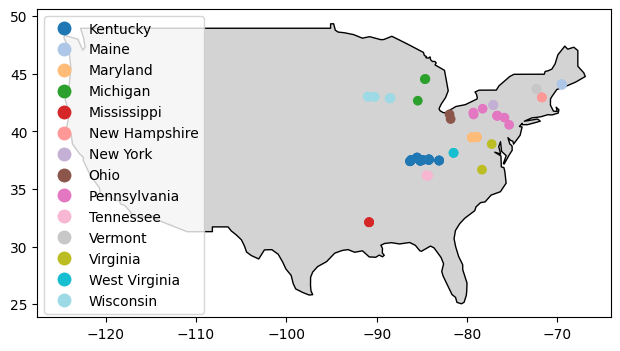

In [138]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Region', cmap= 'tab20',  legend=True, ax=ax);


In [139]:

cluster_assignments = {
    'Maine': 'Northeast',
    'New Hampshire': 'Northeast',
    'Vermont': 'Northeast',
    
    'New York': 'New Yorkish',
    'Pennsylvania': 'New Yorkish',
    'Ohio': 'New Yorkish',
    
    'Maryland': 'Capital',
    'West Virginia': 'Capital',
    'Virginia': 'Capital',
    
    'Michigan': 'Midwest',
    'Wisconsin': 'Midwest',
    
    'Kentucky': 'South',
    
    'Tennessee': 'Super South',
    'Mississippi': 'Super South'
}

tree['RegionCluster'] = tree['Region'].map(cluster_assignments)


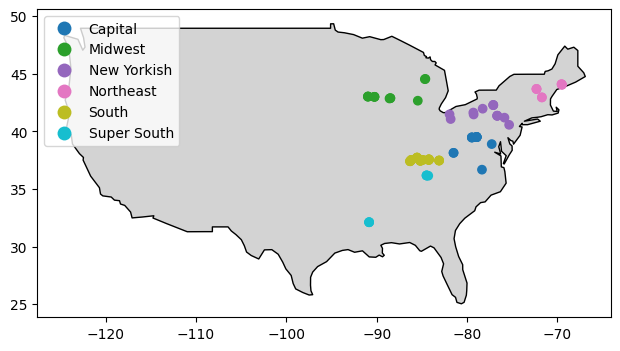

In [140]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='RegionCluster', cmap= 'tab10',  legend=True, ax=ax);

In [141]:
tree.Region.value_counts()

Region
Kentucky         24
Maryland          9
Wisconsin         9
Pennsylvania      8
Maine             4
Tennessee         4
Michigan          3
Vermont           3
New York          3
Mississippi       3
Ohio              2
New Hampshire     2
Virginia          2
West Virginia     2
Name: count, dtype: int64

In [142]:
tree.RegionCluster.value_counts()

RegionCluster
South          24
New Yorkish    13
Capital        13
Midwest        12
Northeast       9
Super South     7
Name: count, dtype: int64

In [143]:
#list(tree.columns)

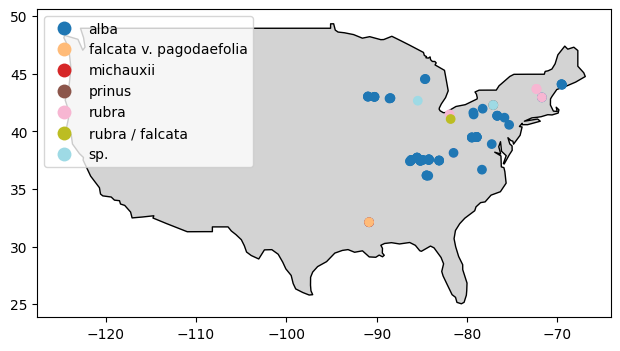

In [147]:
# to see what species we are working with 

fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Species', cmap= 'tab20',  legend=True, ax=ax);


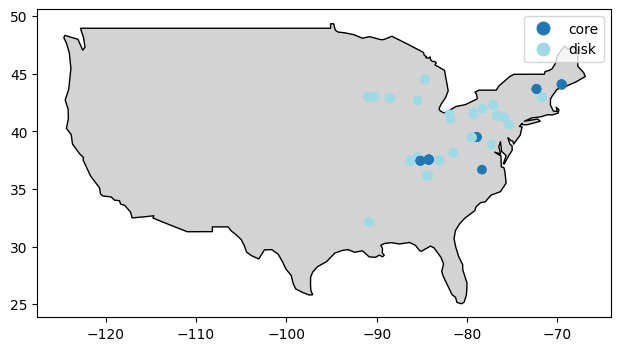

In [146]:
# to see what types of samples we are working with 

fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree.plot(column='Type of sample', cmap= 'tab20',  legend=True, ax=ax);


#### now we hot encode ?? Maybe not needed just yet actually 
- Type of sample
- Species 


In [148]:
tree_encoded = pd.get_dummies(
    tree,
    columns=['Species', 'Type of sample'],
    drop_first=False  # keep all categories
)


In [149]:
#list(tree_encoded.columns)

# Oxygen model furrst 

In [156]:
features = ['Latitude']
target = 'd18O'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.59
Cross-Validated R²: 0.53
AIC: 141.11
BIC: 143.46


In [158]:
features = ['Latitude', 'elevation_dem']
target = 'd18O'
region= 'RegionCluster'

# define model inputs 
df_model = tree[features + [target]+ [region]].dropna()
X = df_model[features].values
y = df_model[target].values
regional_groups = df_model['RegionCluster'].values

# make spatial validation groups 
group_kfold = GroupKFold(n_splits=6) 
regional_kfold = group_kfold.split(X, y, regional_groups )  
train_indices, test_indices = [list(traintest) for traintest in zip(*regional_kfold)]
regional_groups_cv = [*zip(train_indices,test_indices)]

# model + CV predictions
model = LinearRegression()
predictions = cross_val_predict(model, X, y, cv=regional_groups_cv)
model.fit(X, y)

# R2 and RMSE calculations and metrics
rmse = np.sqrt(mean_squared_error(y, predictions))
r2 = r2_score(y, predictions)
print(f"Cross-Validated RMSE: {rmse:.2f}")
print(f"Cross-Validated R²: {r2:.2f}")

# AIC and BIC calculations
n = len(y)  
k = X.shape[1]  

mse = mean_squared_error(y, predictions)
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - predictions) ** 2)

aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

#add prediction to dataframe 
tree[f'{target}_pred_with_{features}']= predictions

Cross-Validated RMSE: 0.57
Cross-Validated R²: 0.56
AIC: 137.94
BIC: 142.66


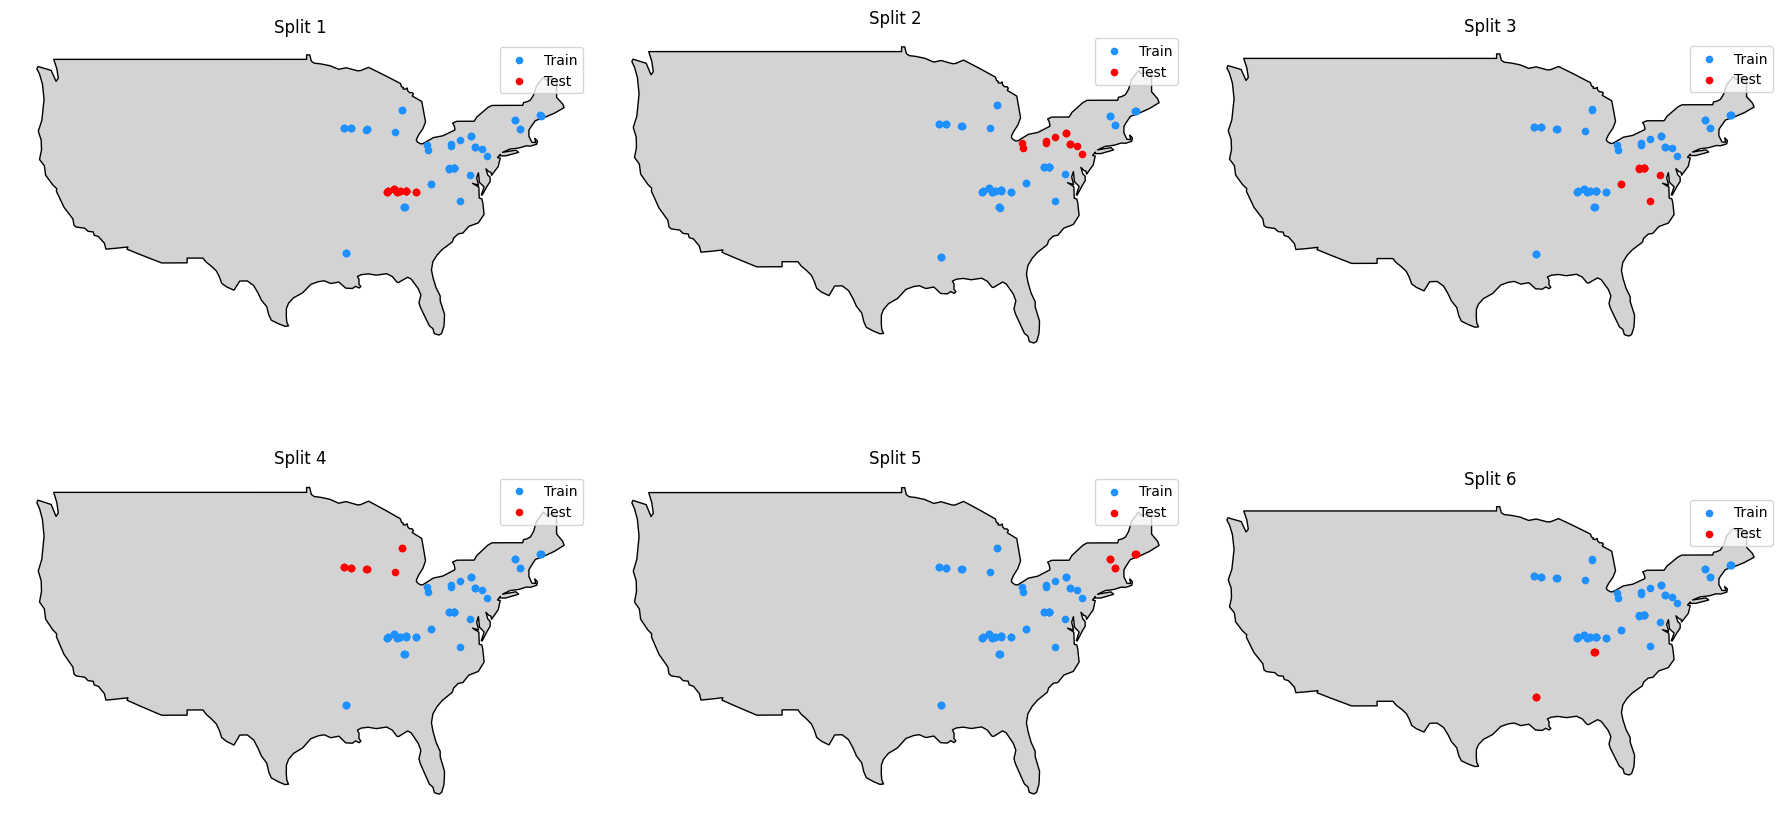

In [151]:
#create plot of the testing/ training sites 

#make same as the model just used 
tree_model = tree.loc[df_model.index]

#make the plots 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  

axes = axes.flatten()

for i, (train_idx, test_idx) in enumerate(regional_groups_cv):
    
    train_data = tree_model.iloc[train_idx]
    test_data = tree_model.iloc[test_idx]
    
    ax = axes[i]
    usa.plot(ax=ax, color='lightgray', edgecolor='black')  
    train_data.plot(ax=ax, color='dodgerblue', markersize=20, label='Train')
    test_data.plot(ax=ax, color='red', markersize=20, label='Test')

    ax.legend()
    ax.set_title(f'Split {i+1}')
    ax.set_axis_off()


plt.tight_layout()
plt.show()


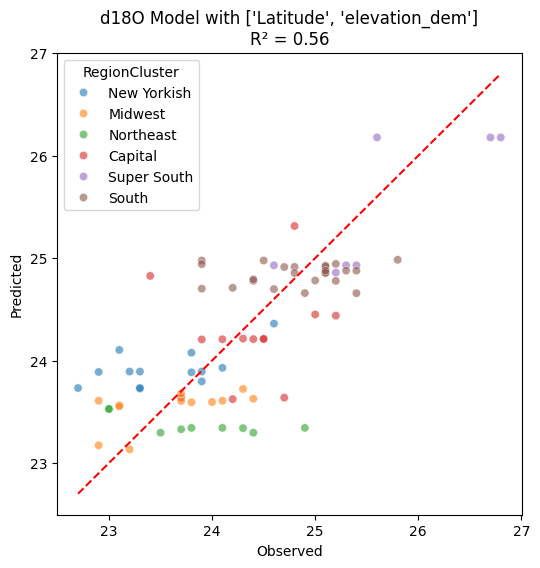

In [159]:
#plot pred vs obs

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=tree,
    x='d18O',
    y="d18O_pred_with_['Latitude', 'elevation_dem']",
    hue='RegionCluster',   
    palette='tab10',     
    alpha=0.6
)

# 1:1 line
plt.plot([tree['d18O'].min(), tree['d18O'].max()],
         [tree['d18O'].min(), tree['d18O'].max()], 'r--')

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(f"{target} Model with {features}\nR² = {r2:.2f}")
plt.show()
